/home/patel_zeel/miniconda3/envs/probml_py3912/lib/python3.9/site-packages/probml_utils/plotting.py:74: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


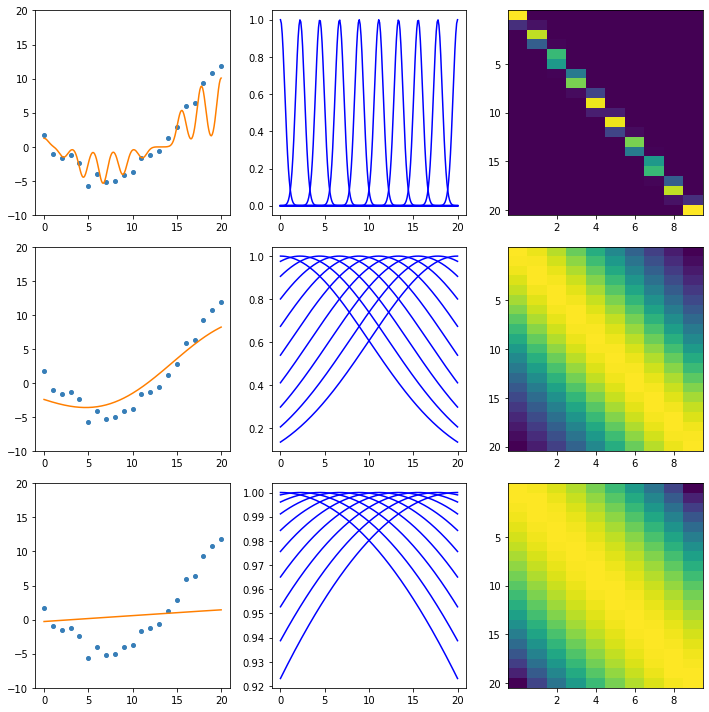

In [2]:
import numpy as np
import matplotlib.pyplot as plt

try:
    from cycler import cycler
except ModuleNotFoundError:
    %pip install -qq cycler
    from cycler import cycler
from scipy.spatial.distance import cdist

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

np.random.seed(0)
CB_color = ["#377eb8", "#ff7f00"]

cb_cycler = cycler(linestyle=["-", "--", "-."]) * cycler(color=CB_color)
plt.rc("axes", prop_cycle=cb_cycler)


def fun(x, w):
    return w[0] * x + w[1] * np.square(x)


# 'Data as mentioned in the matlab code'
def polydatemake():
    n = 21
    sigma = 2
    xtrain = np.linspace(0, 20, n)
    xtest = np.arange(0, 20.1, 0.1)
    w = np.array([-1.5, 1 / 9])
    ytrain = fun(xtrain, w).reshape(-1, 1) + np.random.randn(xtrain.shape[0], 1)
    ytestNoisefree = fun(xtest, w)
    ytestNoisy = ytestNoisefree + sigma * np.random.randn(xtest.shape[0], 1) * sigma

    return xtrain, ytrain, xtest, ytestNoisefree, ytestNoisy


[xtrain, ytrain, xtest, ytestNoisefree, ytestNoisy] = polydatemake()

sigmas = [0.5, 10, 50]
K = 10
centers = np.linspace(np.min(xtrain), np.max(xtrain), K)


def addones(x):
    # x is of shape (s,)
    return np.insert(x[:, np.newaxis], 0, [[1]], axis=1)


def rbf_features(X, centers, sigma):
    dist_mat = cdist(X, centers, "minkowski", p=2.0)
    return np.exp((-0.5 / (sigma**2)) * (dist_mat**2))


# using matrix inversion for ridge regression
def ridgeReg(X, y, lambd):  # returns weight vectors.
    D = X.shape[1]
    w = np.linalg.inv(X.T @ X + lambd * np.eye(D, D)) @ X.T @ y

    return w


fig, ax = plt.subplots(3, 3, figsize=(10, 10))
plt.tight_layout()

for (i, s) in enumerate(sigmas):
    rbf_train = rbf_features(addones(xtrain), addones(centers), s)
    rbf_test = rbf_features(addones(xtest), addones(centers), s)
    reg_w = ridgeReg(rbf_train, ytrain, 0.3)
    ypred = rbf_test @ reg_w

    ax[i, 0].plot(xtrain, ytrain, ".", markersize=8)
    ax[i, 0].plot(xtest, ypred)
    ax[i, 0].set_ylim([-10, 20])
    ax[i, 0].set_xticks(np.arange(0, 21, 5))

    for j in range(K):
        ax[i, 1].plot(xtest, rbf_test[:, j], "b-")
        ax[i, 1].set_xticks(np.arange(0, 21, 5))
        ax[i, 1].ticklabel_format(style="sci", scilimits=(-2, 2))

    ax[i, 2].imshow(rbf_train, interpolation="nearest", aspect="auto", cmap=plt.get_cmap("viridis"))
    ax[i, 2].set_yticks(np.arange(20, 4, -5))
    ax[i, 2].set_xticks(np.arange(2, 10, 2))
pml.savefig("rbfDemoALL.pdf", dpi=300)
plt.show()